In [129]:
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import exists

### Definition of reference potential

In [130]:
class potential:
    def __init__(self, x, y, q):
        self.point_x = x
        self.point_y = y
        self.point_charge = q

### Object for many potentials

In [131]:
class MUL_potential:
    def __init__(self, x_arr: np.array([]), y_arr: np.array([]), charge_arr: np.array([])):
        if(len(x_arr) != len(y_arr) or len(x_arr) != len(charge_arr)):
            print("Can't initialize using arrays of different length.")

        else:
            self.potentials = np.array([])

            for i in range(0, len(x_arr)):
                self.potentials = np.append(self.potentials, potential(x_arr[i], y_arr[i], charge_arr[i]))

### Definition of particle

In [132]:
class particle:
    def __init__(self, alpha, d, q):
        self.particle_angle = alpha
        self.particle_len = d
        self.particle_charge = q

        #first electron
        self.e1_x = self.particle_len * math.cos((math.pi / 180) * self.particle_angle)
        self.e1_y = self.particle_len * math.sin((math.pi / 180) * self.particle_angle)

        #2nd electron
        self.e2_x = self.particle_len * math.cos((math.pi / 180) * (self.particle_angle + 120))
        self.e2_y = self.particle_len * math.sin((math.pi / 180) * (self.particle_angle + 120))

        #3rd electron
        self.e3_x = self.particle_len * math.cos((math.pi / 180) * (self.particle_angle + 240))
        self.e3_y = self.particle_len * math.sin((math.pi / 180) * (self.particle_angle + 240))

### Functions for potential and energy for single reference potential

In [133]:
def getPotential(p: particle, r: potential):
    v1 = 1.0 / (math.sqrt(math.pow(r.point_x - p.e1_x, 2) + math.pow(r.point_y - p.e1_y, 2)))
    v2 = 1.0 / (math.sqrt(math.pow(r.point_x - p.e2_x, 2) + math.pow(r.point_y - p.e2_y, 2)))
    v3 = 1.0 / (math.sqrt(math.pow(r.point_x - p.e3_x, 2) + math.pow(r.point_y - p.e3_y, 2)))

    return v1 + v2 + v3

def getEnergy(p: particle, r: potential):
    k_c = 8.9875517923 * 1.60217662 / 10

    return k_c * r.point_charge * p.particle_charge * getPotential(p, r)

### Energy for multiple potentials

In [134]:
def getEnergy_MUL(p: particle, pot: MUL_potential):
    k_c = 8.9875517923 * 1.60217662 / 10
    acc = 0

    for i in range(0, len(pot.potentials)):
        r = pot.potentials[i]
        acc += k_c * r.point_charge * p.particle_charge * getPotential(p, r)

    return acc

### Function to rotate particle with single potential

In [135]:
def tryRotating(p: particle, r: potential, alpha, T):
    #create particle at new angle
    p1 = particle(p.particle_angle + alpha, p.particle_len, p.particle_charge)

    #get old and new energy
    E_old = getEnergy(p, r)
    E_new = getEnergy(p1, r)

    #boltzmann constant in [eV/K]
    k_b = 8.617333262145 * math.pow(10, -5)

    #if new energy is lower than old, return new angle
    if(E_new - E_old < 0):
        return p1

    else:
        w = math.exp(-(E_new - E_old) / (T * k_b))
        rand = random.random()

        if(rand <= w):
            return p1
        else:
            return p

### Rotating for multiple potentials

In [136]:
def tryRotating_MUL(p: particle, pot: MUL_potential, alpha, T):
    #create particle at new angle
    p1 = particle(p.particle_angle + alpha, p.particle_len, p.particle_charge)

    #get old and new energy
    E_old = getEnergy_MUL(p, pot)
    E_new = getEnergy_MUL(p1, pot)

    #boltzmann constant in [eV/K]
    k_b = 8.617333262145 * math.pow(10, -5)

    #if new energy is lower than old, return new angle
    if(E_new - E_old < 0):
        return p1

    else:
        w = math.exp(-(E_new - E_old) / (T * k_b))
        rand = random.random()

        if(rand <= w):
            return p1
        else:
            return p

### Order parameter

In [137]:
def order_ite(p: particle):
    cos_ite = round(math.cos((math.pi / 180) * (3 * p.particle_angle)), 5)
    sin_ite = round(math.sin((math.pi / 180) * (3 * p.particle_angle)), 5)

    return cos_ite, sin_ite

def order_full(cos, sin, steps):
    thet = 0.0

    #get mean
    cos = cos / steps
    sin = sin / steps

    #get theta
    thet = math.atan(sin / cos)

    #cube them
    cos = math.pow(cos, 2)
    sin = math.pow(sin, 2)

    return cos + sin, thet

### Physical constants and variables for simulation

In [138]:
#physical stuff - charge is in [e], distances are in [nm]
phi = 0.5
T = 5 * pow(10, -3)

#multipliers for particle
d1 = 0.2
Q2 = 0.5

#multipliers for potential
d2 = 90
#pot_x = d2
#pot_y = 0
pot_x = np.array([d2, d2 * math.cos((math.pi / 180) * 120), d2 * math.cos((math.pi / 180) * 240)])
pot_y = np.array([0, d2 * math.sin((math.pi / 180) * 120), d2 * math.sin((math.pi / 180) * 240)])
#pot_x = np.array([d2, 0, -d2, 0])
#pot_y = np.array([0, d2, 0, -d2])
#pot_x = np.array([d2, d2 * math.cos((math.pi / 180) * 72), d2 * math.cos((math.pi / 180) * 144), d2 * math.cos((math.pi / 180) * 216), d2 * math.cos((math.pi / 180) * 288)])
#pot_y = np.array([0, d2 * math.sin((math.pi / 180) * 72), d2 * math.sin((math.pi / 180) * 144), d2 * math.sin((math.pi / 180) * 216), d2 * math.sin((math.pi / 180) * 288)])
Q1 = -300
#pot_q = Q1
pot_q = np.array([Q1, Q1, Q1])
AngleInt = int(60 / phi)

#MC steps
mc = 2000000

### Creation of particle and reference potentials

In [139]:
p = particle(0, d1, Q2)

#multiple potentials
ref = MUL_potential(pot_x, pot_y, pot_q)

### Array to keep track of particle position and energy for quick plotting

In [140]:
#count based on angle - empty dictionaries
avg = {}
avg_1st = {}
avg_2nd = {}

#energy based on MC step
en_mc1 = np.array([])
en_mc2 = np.array([])
en_mc3 = np.array([])
en_mc4 = np.array([])
en_mc5 = np.array([])
en_mc6 = np.array([])
en_mc7 = np.array([])
en_mc8 = np.array([])
en_mc9 = np.array([])
en_mc10 = np.array([])

#angle based on MC step
ang_mc1 = np.array([])
ang_mc2 = np.array([])
ang_mc3 = np.array([])
ang_mc4 = np.array([])
ang_mc5 = np.array([])
ang_mc6 = np.array([])
ang_mc7 = np.array([])
ang_mc8 = np.array([])
ang_mc9 = np.array([])
ang_mc10 = np.array([])

#order parameter
cos = 0
sin = 0
cos_mc1 = np.array([])
sin_mc1 = np.array([])
cos_mc2 = np.array([])
sin_mc2 = np.array([])
cos_mc3 = np.array([])
sin_mc3 = np.array([])
cos_mc4 = np.array([])
sin_mc4 = np.array([])
cos_mc5 = np.array([])
sin_mc5 = np.array([])
cos_mc6 = np.array([])
sin_mc6 = np.array([])
cos_mc7 = np.array([])
sin_mc7 = np.array([])
cos_mc8 = np.array([])
sin_mc8 = np.array([])
cos_mc9 = np.array([])
sin_mc9 = np.array([])
cos_mc10 = np.array([])
sin_mc10 = np.array([])

#count of cos/sin
cos_map = {}
sin_map = {}

### Main loop for rotating particle

In [141]:
for i in range(0, mc):

    #generate random number to check which way we're gonna rotate
    rng = random.random()

    #rotate counter-clockwise
    if(rng > 0.5):
        p = tryRotating_MUL(p, ref, phi, T)
    #rotate clockwise
    else:
        p = tryRotating_MUL(p, ref, -phi, T)


    #calculate cos and sin for order parameter
    cos_ite, sin_ite = order_ite(p)
    cos += cos_ite
    sin += sin_ite


    #get all the values needed for graphs based on mc step
    if(i >= 10000 and i < 100000):
        en_mc1 = np.append(en_mc1, getEnergy_MUL(p, ref)) #energy
        ang_mc1 = np.append(ang_mc1, p.particle_angle)    #angle
        cos_mc1 = np.append(cos_mc1, cos_ite)             #cosine
        sin_mc1 = np.append(sin_mc1, sin_ite)             #sine
    if(i >= 100000 and i < 200000):
        en_mc2 = np.append(en_mc2, getEnergy_MUL(p, ref)) #energy
        ang_mc2 = np.append(ang_mc2, p.particle_angle)    #angle
        cos_mc2 = np.append(cos_mc2, cos_ite)             #cosine
        sin_mc2 = np.append(sin_mc2, sin_ite)             #sine
    if(i >= 200000 and i < 300000):
        en_mc3 = np.append(en_mc3, getEnergy_MUL(p, ref)) #energy
        ang_mc3 = np.append(ang_mc3, p.particle_angle)    #angle
        cos_mc3 = np.append(cos_mc3, cos_ite)             #cosine
        sin_mc3 = np.append(sin_mc3, sin_ite)             #sine   
    if(i >= 300000 and i < 400000):
        en_mc4 = np.append(en_mc4, getEnergy_MUL(p, ref)) #energy
        ang_mc4 = np.append(ang_mc4, p.particle_angle)    #angle
        cos_mc4 = np.append(cos_mc4, cos_ite)             #cosine
        sin_mc4 = np.append(sin_mc4, sin_ite)             #sine
    if(i >= 400000 and i < 500000):
        en_mc5 = np.append(en_mc5, getEnergy_MUL(p, ref)) #energy
        ang_mc5 = np.append(ang_mc5, p.particle_angle)    #angle
        cos_mc5 = np.append(cos_mc5, cos_ite)             #cosine
        sin_mc5 = np.append(sin_mc5, sin_ite)             #sine 
    if(i >= 500000 and i < 600000):
        en_mc6 = np.append(en_mc6, getEnergy_MUL(p, ref)) #energy
        ang_mc6 = np.append(ang_mc6, p.particle_angle)    #angle
        cos_mc6 = np.append(cos_mc6, cos_ite)             #cosine
        sin_mc6 = np.append(sin_mc6, sin_ite)             #sine
    if(i >= 600000 and i < 700000):
        en_mc7 = np.append(en_mc7, getEnergy_MUL(p, ref)) #energy
        ang_mc7 = np.append(ang_mc7, p.particle_angle)    #angle
        cos_mc7 = np.append(cos_mc7, cos_ite)             #cosine
        sin_mc7 = np.append(sin_mc7, sin_ite)             #sine 
    if(i >= 700000 and i < 800000):
        en_mc8 = np.append(en_mc8, getEnergy_MUL(p, ref)) #energy
        ang_mc8 = np.append(ang_mc8, p.particle_angle)    #angle
        cos_mc8 = np.append(cos_mc8, cos_ite)             #cosine
        sin_mc8 = np.append(sin_mc8, sin_ite)             #sine
    if(i >= 800000 and i < 900000):
        en_mc9 = np.append(en_mc9, getEnergy_MUL(p, ref)) #energy
        ang_mc9 = np.append(ang_mc9, p.particle_angle)    #angle
        cos_mc9 = np.append(cos_mc9, cos_ite)             #cosine
        sin_mc9 = np.append(sin_mc9, sin_ite)             #sine  
    if(i >= 900000 and i < 1000000):
        en_mc10 = np.append(en_mc10, getEnergy_MUL(p, ref)) #energy
        ang_mc10 = np.append(ang_mc10, p.particle_angle)    #angle
        cos_mc10 = np.append(cos_mc10, cos_ite)             #cosine
        sin_mc10 = np.append(sin_mc10, sin_ite)             #sine 
        

    #increase the count of cos
    if(cos_map.keys().__contains__(cos_ite) == True):
        cos_map[cos_ite] += 1    
    else: #new value - start count from 1
        cos_map[cos_ite] = 1    

    
    #increase the count of sin
    if(sin_map.keys().__contains__(sin_ite) == True):
        sin_map[sin_ite] += 1    
    else: #new value - start count from 1
        sin_map[sin_ite] = 1 


    #increase the count of new angle by 1 for all steps
    if(avg.keys().__contains__(p.particle_angle) == True):
        avg[p.particle_angle] += 1    
    else: #new angle - start count from 1
        avg[p.particle_angle] = 1


    #increase the count of new angle by 1 for 1st 1,000,000 steps
    if(i < 1000000):
        if(avg_1st.keys().__contains__(p.particle_angle) == True): #dictionary contains the angle - increase the count by 1
            avg_1st[p.particle_angle] += 1    
        else: #new angle - start count from 1
            avg_1st[p.particle_angle] = 1    
    #increase the count of new angle by 1 for 2nd 1,000,000 steps
    else:
        if(avg_2nd.keys().__contains__(p.particle_angle) == True): #dictionary contains the angle - increase the count by 1
            avg_2nd[p.particle_angle] += 1    
        else: #new angle - start count from 1
            avg_2nd[p.particle_angle] = 1


    #write iteration progress
    if(i % 100000 == 0):
        print("Iteration progress:\t" + str(i))


#normalize the count of cos/sin
for i in cos_map.keys():
    cos_map[i] = cos_map[i] / (mc / 100) #normalized between 0 and 100%
for i in sin_map.keys():
    sin_map[i] = sin_map[i] / (mc / 100) #normalized between 0 and 100%


#normalize the count at each angle
for i in avg.keys():
    avg[i] = avg[i] / (mc / 100) #normalized between 0 and 100%
for i in avg_1st.keys():
    avg_1st[i] = avg_1st[i] / (mc / 200)    
for i in avg_2nd.keys():
    avg_2nd[i] = avg_2nd[i] / (mc / 200)
    

#order parameter and theta
order, theta = order_full(cos, sin, mc)

Iteration progress:	0
Iteration progress:	100000
Iteration progress:	200000
Iteration progress:	300000
Iteration progress:	400000
Iteration progress:	500000
Iteration progress:	600000
Iteration progress:	700000
Iteration progress:	800000
Iteration progress:	900000
Iteration progress:	1000000
Iteration progress:	1100000
Iteration progress:	1200000
Iteration progress:	1300000
Iteration progress:	1400000
Iteration progress:	1500000
Iteration progress:	1600000
Iteration progress:	1700000
Iteration progress:	1800000
Iteration progress:	1900000


### Opening files to append

In [142]:
#checking which run we're on
for i in range(0, 1000):
    if(exists('Results\\' + str(i) + '_Angle_Count.csv') == False):
        run = i
        break

#positions of potentials
R = ""
if(type(ref) == potential):
    R = "(" + str(pot_x) + ", " + str(pot_y) + ")"

else:
    for i in range(0, len(pot_x)):
        R += "(" + str(pot_x[i]) + ", " + str(pot_y[i]) + ")"

#save parameters
params = open('Results\parameters.txt', 'a+')
params.write("\n===========\n")
params.write("Run " + str(run) +  "\n===========\n")
params.write("Q1 = " + str(Q1) + "\nQ2 = " + str(Q2) + "\nd = " + str(d1) + "\nR = " + R + " \nphi = " + str(phi) + "\nT = " + str(T) + "\nOrder = " + str(order) + "\nTheta = " + str(theta))
params.close()

### Save to file

In [143]:
### Energy based on mc step
index = np.arange(10000, 1000000, 1, dtype = int)
en_mc = pd.DataFrame(np.concatenate((en_mc1, en_mc2, en_mc3, en_mc4, en_mc5, en_mc6, en_mc7, en_mc8, en_mc9, en_mc10), axis = 0), columns = ['Energy'])
en_mc = en_mc.set_index(index)
pd.DataFrame.to_csv(en_mc, 'Results\\' + str(run) + '_MC_Energy.csv')

### Angle based on mc step
ang_mc = pd.DataFrame(np.concatenate((ang_mc1, ang_mc2, ang_mc3, ang_mc4, ang_mc5, ang_mc6, ang_mc7, ang_mc8, ang_mc9, ang_mc10), axis = 0), columns = ['Angle'])
ang_mc = ang_mc.set_index(index)
pd.DataFrame.to_csv(ang_mc, 'Results\\' + str(run) + '_MC_Count.csv')

### cos and sin based on mc step
trig_mc = pd.DataFrame(list(zip(np.concatenate((cos_mc1, cos_mc2, cos_mc3, cos_mc4, cos_mc5, cos_mc6, cos_mc7, cos_mc8, cos_mc9, cos_mc10), axis = 0), \
                                np.concatenate((sin_mc1, sin_mc2, sin_mc3, sin_mc4, sin_mc5, sin_mc6, sin_mc7, sin_mc8, sin_mc9, sin_mc10), axis = 0)))\
                                , columns = ['Cosine', 'Sine'])
trig_mc = trig_mc.set_index(index)
pd.DataFrame.to_csv(trig_mc, 'Results\\' + str(run) + '_MC_Trig.csv')

### cos and sin based on value
cos_map = pd.DataFrame.from_dict(cos_map, orient = 'index', columns = ['occurences'])
sin_map = pd.DataFrame.from_dict(sin_map, orient = 'index', columns = ['occurences'])
pd.DataFrame.to_csv(cos_map, 'Results\\' + str(run) + '_Cos_Count.csv')
pd.DataFrame.to_csv(sin_map, 'Results\\' + str(run) + '_Sin_Count.csv')

### Count of times particle was at particular angle
avg = pd.DataFrame.from_dict(avg, orient = 'index', columns = ['total'])
avg['1st'] = pd.DataFrame.from_dict(avg_1st, orient = 'index')
avg['2nd'] = pd.DataFrame.from_dict(avg_2nd, orient = 'index')
pd.DataFrame.to_csv(avg, 'Results\\' + str(run) + '_Angle_Count.csv')

### Graph of energy dependence on MC step

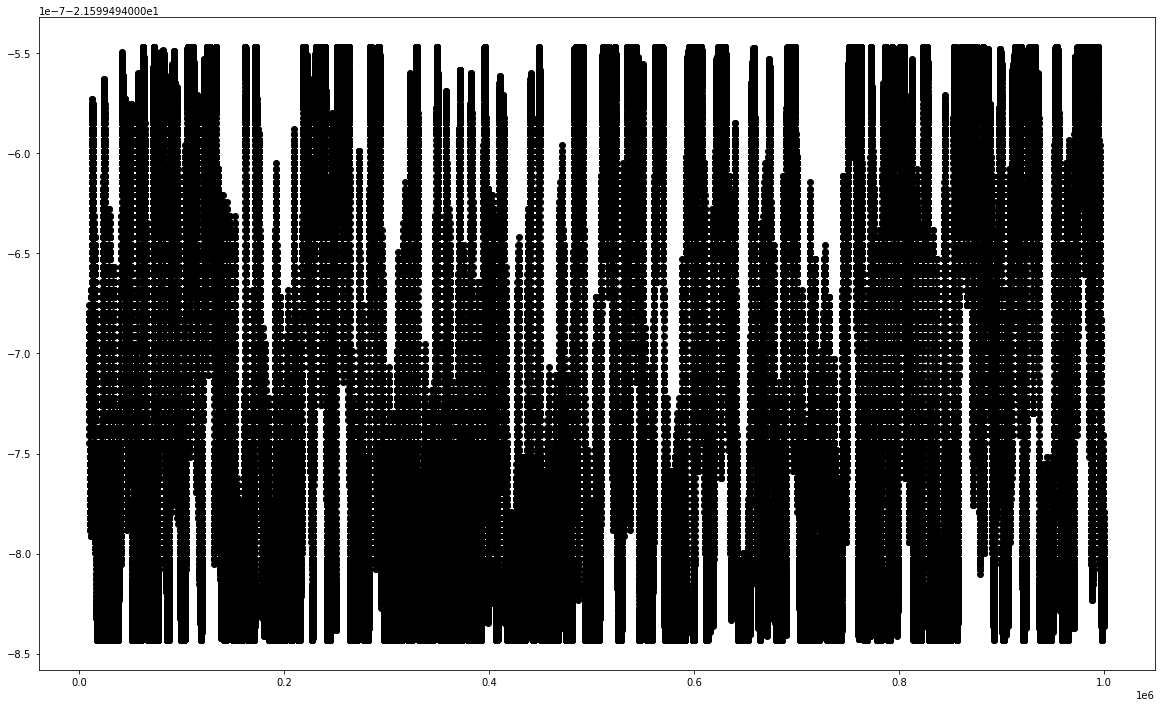

In [144]:
plt.figure(figsize = (20, 12))
plt.plot(en_mc, marker = "o", color = "black")

### Graph of Count of particle based on angle

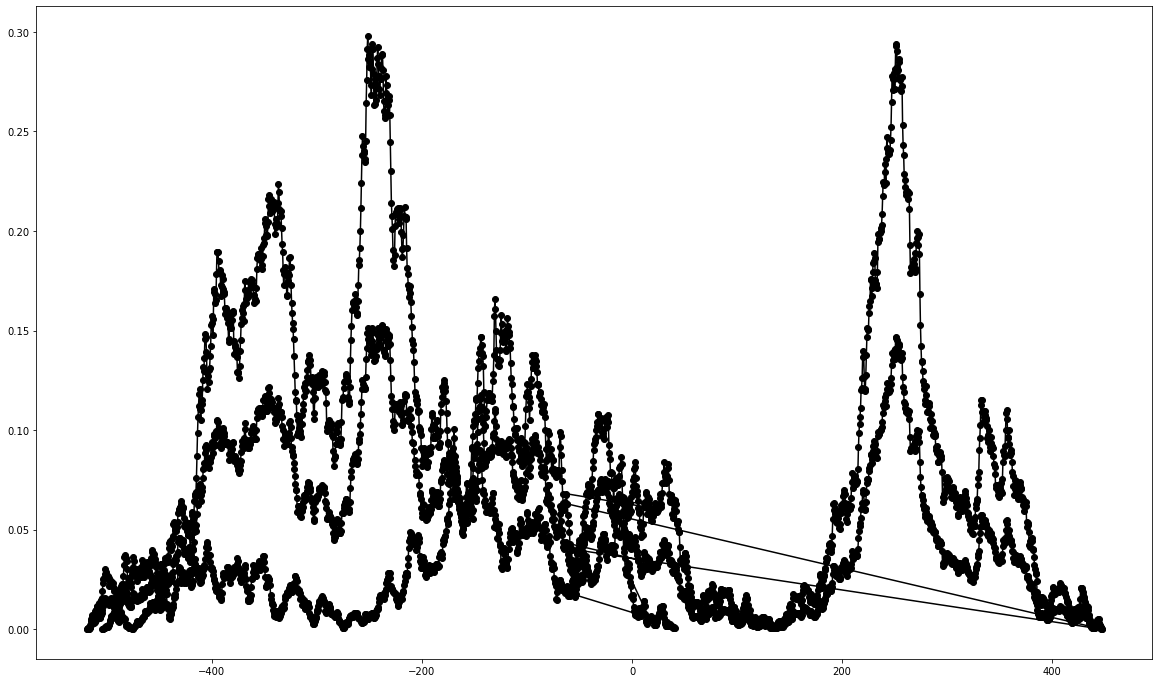

In [145]:
plt.figure(figsize = (20, 12))
plt.plot(avg, marker = "o", color = "black")

### Energy dependence on angle

In [146]:
df = np.array([])
index = np.array([])

for i in range(-AngleInt, AngleInt):
    p = particle(i * phi, d1, Q2)

    #single potential
    if(type(ref) == potential):
        df = np.append(df, getEnergy(p, ref))
    
    #multiple potentials
    else:
        df = np.append(df, getEnergy_MUL(p, ref))
        
    index = np.append(index, i * phi)

#convert to pandas dataframe
df = pd.DataFrame(df, columns = ['Energy'])
df = df.set_index(index)

#save to csv
pd.DataFrame.to_csv(df, 'Results\\' + str(run) + '_Angle_Energy.csv')

### Graph of Energy dependence on angle

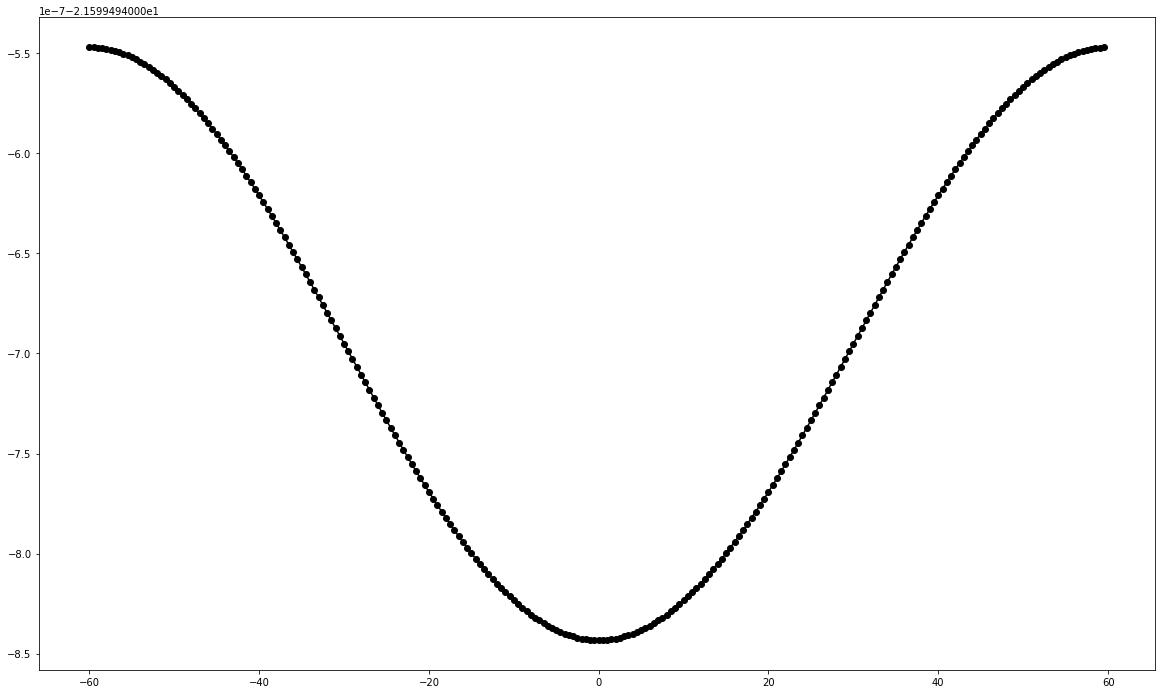

In [147]:
plt.figure(figsize = (20, 12))
plt.plot(df, marker = "o", color = "black")